In [ ]:
#Gradient Boost trained with linear data, with data augmentation SAME for each label and using labels-v4

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import os
import time

In [2]:
# nombre de instancia
# número restricciones
# número variables
# porcentaje de restricciones unarias, binarias, porcentaje de ternarias, porcentaje cuaternarias o más 
# porcentaje de terminos en la función obj
# porcentaje de terminos positivos/negativos en restricciones
# porcentaje de terminos positivos/negativos en funcion obj
# timestep
# solver (label)

main_path="/global/scratch/users/cpezov/AAPBO/"
d_path=main_path+"datasets-v4/"
d_lin_path=main_path+"datasets_linear-v4/"
feat_path=d_lin_path+"features/"

columns = ["# contraints","# variables","% 1 term constr","% 2 terms constr","% 3 terms constr","% 4+ terms constr","% terms in obj func","% positive in constr","% positive in obj func","timestep","solver"]
names=[]
num_rest=[]
num_var=[]
r_unary=[]
r_binary=[]
r_ternary=[]
r_cuaternary=[]
t_fo=[]
t_pos_r=[]
t_pos_fo=[]
timestep=[]
solvers=[]

#Recolectar data de txt files
with open(d_path+"txt_files/data_ordered.txt") as f:
    lines = f.readlines()
    for l in lines:
        words=l.split()
        bench=words[0][words[0].find("/")+1:words[0].rfind("/")]
        name=words[0][words[0].rfind("/")+1:words[0].rfind(".")]
        name=name+".linearized"
        print(bench,name)
        with open(feat_path+bench+"/"+name) as feat_f:
            l=feat_f.readlines()
            w=l[0].split()
            for n in range(500): #repetir 500 cada instancia, para que cuadre con los timesteps
                names.append(w[0])
                num_rest.append(int(w[1]))
                num_var.append(int(w[2]))
                r_unary.append(float(w[3]))
                r_binary.append(float(w[4]))
                r_ternary.append(float(w[5]))
                r_cuaternary.append(float(w[6]))
                t_fo.append(float(w[7]))
                t_pos_r.append(float(w[8]))
                t_pos_fo.append(float(w[9]))
                timestep.append(n)
        
with open(main_path+"labels-v4.txt") as f:
    lines = f.readlines()
    for l in lines:
        for word in l.split():
            solvers.append(int(word))

Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-2-irabcde.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-2-irEDCBA.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-1-irabcde.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-1-irEDCBA.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-2-irabcde.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-2-irEDCBA.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-1-irabcde.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-1-irEDCBA.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-1-abcdeir.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-A-3-combined-EDCBAir.linearized
Benchmark1 normalized-single-obj-f4-DataDisplay_2_order9.seq-B-3-combined-irabcde.linearized
Benchmark1 normalized-single-obj-f4-Data

Benchmark10 normalized-single-obj-f46-DC_Side1.seq-A-2-1-irabcde.linearized
Benchmark10 normalized-single-obj-f46-DC_Side1.seq-A-2-1-irEDCBA.linearized
Benchmark10 normalized-single-obj-f46-DC_Side1.seq-B-2-1-irabcde.linearized
Benchmark10 normalized-single-obj-f47-DC_Side1.seq-B-2-combined-irabcde.linearized
Benchmark10 normalized-single-obj-f47-DC_Side1.seq-B-2-combined-irEDCBA.linearized
Benchmark10 normalized-single-obj-f46-DC_Side1.seq-A-2-combined-irEDCBA.linearized
Benchmark10 normalized-single-obj-f46-DC_Side1.seq-A-2-combined-irabcde.linearized
Benchmark11 normalized-single-obj-f49-DC_TotalLoss.seq-A-2-2-irEDCBA.linearized
Benchmark11 normalized-single-obj-f48-DC_TotalLoss.seq-B-2-2-irabcde.linearized
Benchmark11 normalized-single-obj-f48-DC_TotalLoss.seq-B-2-2-irEDCBA.linearized
Benchmark11 normalized-single-obj-f48-DC_TotalLoss.seq-A-2-2-irabcde.linearized
Benchmark11 normalized-single-obj-f48-DC_TotalLoss.seq-B-2-1-irabcde.linearized
Benchmark11 normalized-single-obj-f49-DC

Benchmark17 normalized-autocorr_bern45-45.lin.linearized
Benchmark17 normalized-autocorr_bern60-30.lin.linearized
Benchmark17 normalized-autocorr_bern50-38.lin.linearized
Benchmark17 normalized-autocorr_bern50-50.lin.linearized
Benchmark17 normalized-autocorr_bern55-41.lin.linearized
Benchmark17 normalized-autocorr_bern55-55.lin.linearized
Benchmark17 normalized-autocorr_bern60-45.lin.linearized
Benchmark17 normalized-autocorr_bern60-60.lin.linearized
Benchmark18 normalized-cardqp_inlp.lin.linearized
Benchmark19 normalized-crossdock_15x8.lin.linearized
Benchmark20 normalized-faclay60.lin.linearized
Benchmark20 normalized-faclay70.lin.linearized
Benchmark20 normalized-faclay75.lin.linearized
Benchmark20 normalized-faclay80.lin.linearized
Benchmark21 normalized-graphpart_2g-0044-1601.lin.linearized
Benchmark21 normalized-graphpart_2g-0055-0062.lin.linearized
Benchmark21 normalized-graphpart_2g-0066-0066.lin.linearized
Benchmark21 normalized-graphpart_2g-0077-0077.lin.linearized
Benchmark

Benchmark43 normalized-edgecross10-020.lin.linearized
Benchmark43 normalized-edgecross10-030.lin.linearized
Benchmark43 normalized-edgecross14-019.lin.linearized
Benchmark43 normalized-edgecross10-040.lin.linearized
Benchmark43 normalized-edgecross10-090.lin.linearized
Benchmark43 normalized-edgecross10-050.lin.linearized
Benchmark43 normalized-edgecross10-070.lin.linearized
Benchmark43 normalized-edgecross14-058.lin.linearized
Benchmark43 normalized-edgecross20-040.lin.linearized
Benchmark43 normalized-edgecross14-176.lin.linearized
Benchmark43 normalized-edgecross22-048.lin.linearized
Benchmark43 normalized-edgecross14-098.lin.linearized
Benchmark43 normalized-edgecross14-117.lin.linearized
Benchmark43 normalized-edgecross24-057.lin.linearized
Benchmark43 normalized-edgecross20-080.lin.linearized
Benchmark43 normalized-edgecross14-137.lin.linearized
Benchmark43 normalized-edgecross22-096.lin.linearized
Benchmark43 normalized-edgecross24-115.lin.linearized
Benchmark44 normalized-facla

Benchmark61 normalized-sporttournament06.linearized
Benchmark61 normalized-sporttournament08.linearized
Benchmark61 normalized-sporttournament10.linearized
Benchmark61 normalized-sporttournament12.linearized
Benchmark61 normalized-sporttournament16.linearized
Benchmark61 normalized-sporttournament18.linearized
Benchmark61 normalized-sporttournament20.linearized
Benchmark61 normalized-sporttournament22.linearized
Benchmark61 normalized-sporttournament24.linearized
Benchmark61 normalized-sporttournament26.linearized
Benchmark61 normalized-sporttournament28.linearized
Benchmark61 normalized-sporttournament30.linearized
Benchmark61 normalized-sporttournament32.linearized
Benchmark61 normalized-sporttournament34.linearized
Benchmark61 normalized-sporttournament36.linearized
Benchmark61 normalized-sporttournament38.linearized
Benchmark61 normalized-sporttournament40.linearized
Benchmark61 normalized-sporttournament42.linearized
Benchmark61 normalized-sporttournament44.linearized
Benchmark61 

Benchmark96 normalized-minisat50_6_9_1_ic.linearized
Benchmark96 normalized-minisat50_6_9_0_ic.linearized
Benchmark97 normalized-minisat100_16_6_5_ic.linearized
Benchmark97 normalized-minisat100_16_6_2_ic.linearized
Benchmark97 normalized-minisat100_16_6_4_ic.linearized
Benchmark97 normalized-minisat100_16_6_9_ic.linearized
Benchmark97 normalized-minisat100_16_6_3_ic.linearized
Benchmark97 normalized-minisat100_16_6_6_ic.linearized
Benchmark97 normalized-minisat100_16_6_7_ic.linearized
Benchmark97 normalized-minisat100_16_6_8_ic.linearized
Benchmark97 normalized-minisat100_16_6_1_ic.linearized
Benchmark97 normalized-minisat100_16_6_0_ic.linearized
Benchmark97 normalized-minisat100_16_6_6_mh.linearized
Benchmark97 normalized-minisat100_16_6_0_mh.linearized
Benchmark97 normalized-minisat100_16_6_1_mh.linearized
Benchmark97 normalized-minisat100_16_6_3_mh.linearized
Benchmark97 normalized-minisat100_16_6_7_mh.linearized
Benchmark97 normalized-minisat100_16_6_8_mh.linearized
Benchmark97 no

Benchmark123 normalized-NG.dot_unif_10null20mast_rapportOE2.0_TMAX60_K192_cod2.linearized
Benchmark123 normalized-NG.dot_unif_10null20mast_rapportOE1.0_TMAX300_K192_cod2.linearized
Benchmark123 normalized-NG.dot_unif_10null0mast_rapportOE2.0_TMAX15_K192_cod2.linearized
Benchmark124 normalized-NG.dot_unif_20null20mast_rapportOE2.0_TMAX300_K192_cod2.linearized
Benchmark124 normalized-NG.dot_unif_20null20mast_rapportOE2.0_TMAX15_K192_cod2.linearized
Benchmark124 normalized-NG.dot_unif_20null20mast_rapportOE1.0_TMAX120_K192_cod2.linearized
Benchmark124 normalized-NG.dot_unif_20null0mast_rapportOE2.0_TMAX180_K192_cod2.linearized
Benchmark124 normalized-NG.dot_unif_20null0mast_rapportOE1.0_TMAX300_K192_cod2.linearized
Benchmark125 normalized-NG.dot_unif_50null0mast_rapportOE2.0_TMAX60_K192_cod2.linearized
Benchmark125 normalized-NG.dot_unif_50null50mast_rapportOE1.0_TMAX180_K192_cod2.linearized
Benchmark125 normalized-NG.dot_unif_50null20mast_rapportOE2.0_TMAX120_K192_cod2.linearized
Benchma

Benchmark176 normalized-658.cudf.trendy.linearized
Benchmark176 normalized-1098.cudf.trendy.linearized
Benchmark176 normalized-1093.cudf.trendy.linearized
Benchmark176 normalized-902.cudf.trendy.linearized
Benchmark176 normalized-121.cudf.trendy.linearized
Benchmark176 normalized-557.cudf.trendy.linearized
Benchmark176 normalized-1335.cudf.trendy.linearized
Benchmark177 normalized-randaefc7c.cudf.trendy.linearized
Benchmark177 normalized-rand65d021.cudf.trendy.linearized
Benchmark177 normalized-rand0c02bc.cudf.trendy.linearized
Benchmark177 normalized-randfe95e3.cudf.trendy.linearized
Benchmark177 normalized-rand2d8467.cudf.trendy.linearized
Benchmark177 normalized-randb87834.cudf.trendy.linearized
Benchmark177 normalized-randf7d077.cudf.trendy.linearized
Benchmark177 normalized-randa491d5.cudf.trendy.linearized
Benchmark177 normalized-randd1cab2.cudf.trendy.linearized
Benchmark177 normalized-rand6d579e.cudf.trendy.linearized
Benchmark177 normalized-rand659e05.cudf.trendy.linearized
Be

Benchmark186 normalized-j9013_9.std.linearized
Benchmark186 normalized-j9020_8.std.linearized
Benchmark186 normalized-j9025_7.std.linearized
Benchmark186 normalized-j9021_5.std.linearized
Benchmark186 normalized-j9019_6.std.linearized
Benchmark186 normalized-j9027_6.std.linearized
Benchmark186 normalized-j9023_3.std.linearized
Benchmark186 normalized-j9025_10.std.linearized
Benchmark186 normalized-j9022_8.std.linearized
Benchmark186 normalized-j9024_9.std.linearized
Benchmark186 normalized-j9017_9.std.linearized
Benchmark186 normalized-j9027_5.std.linearized
Benchmark186 normalized-j9031_6.std.linearized
Benchmark186 normalized-j9043_5.std.linearized
Benchmark186 normalized-j9045_2.std.linearized
Benchmark186 normalized-j9039_4.std.linearized
Benchmark186 normalized-j9038_7.std.linearized
Benchmark186 normalized-j9043_10.std.linearized
Benchmark186 normalized-j9044_5.std.linearized
Benchmark186 normalized-j9041_1.std.linearized
Benchmark186 normalized-j9033_3.std.linearized
Benchmark18

Benchmark199 normalized-fir07_trarea_ac.linearized
Benchmark199 normalized-fir09_trarea_ac.linearized
Benchmark199 normalized-fir06_trarea_ac.linearized
Benchmark199 normalized-fir08_trarea_ac.linearized
Benchmark199 normalized-fir10_trarea_ac.linearized
Benchmark200 normalized-reduced-fir05_trarea_ac.linearized
Benchmark200 normalized-reduced-fir03_trarea_ac.linearized
Benchmark200 normalized-reduced-fir04_trarea_ac.linearized
Benchmark200 normalized-reduced-fir07_trarea_ac.linearized
Benchmark200 normalized-reduced-fir09_trarea_ac.linearized
Benchmark200 normalized-reduced-fir06_trarea_ac.linearized
Benchmark200 normalized-reduced-fir08_trarea_ac.linearized
Benchmark200 normalized-reduced-fir10_trarea_ac.linearized
Benchmark201 normalized-fir01_area_delay.linearized
Benchmark201 normalized-fir02_area_delay.linearized
Benchmark201 normalized-fir04_area_delay.linearized
Benchmark201 normalized-fir05_area_delay.linearized
Benchmark201 normalized-fir03_area_delay.linearized
Benchmark201 

Benchmark216 normalized-mds_100_10_3.linearized
Benchmark216 normalized-mds_100_10_2.linearized
Benchmark216 normalized-mds_100_10_1.linearized
Benchmark217 normalized-mds_200_25_5.linearized
Benchmark217 normalized-mds_200_25_4.linearized
Benchmark217 normalized-mds_200_25_3.linearized
Benchmark217 normalized-mds_200_25_2.linearized
Benchmark217 normalized-mds_200_25_1.linearized
Benchmark217 normalized-mds_200_10_5.linearized
Benchmark217 normalized-mds_200_10_4.linearized
Benchmark217 normalized-mds_200_10_3.linearized
Benchmark217 normalized-mds_200_10_2.linearized
Benchmark217 normalized-mds_200_10_1.linearized
Benchmark218 normalized-mds_500_60_5.linearized
Benchmark218 normalized-mds_500_60_4.linearized
Benchmark218 normalized-mds_500_10_1.linearized
Benchmark218 normalized-mds_500_60_2.linearized
Benchmark218 normalized-mds_500_60_1.linearized
Benchmark218 normalized-mds_500_25_5.linearized
Benchmark218 normalized-mds_500_25_4.linearized
Benchmark218 normalized-mds_500_25_3.lin

Benchmark227 factor-mod-size=6-P0=2-P1=31-P2=13-P3=31-P4=31-B.linearized
Benchmark227 factor-mod-size=6-P0=53-P1=13-P2=23-P3=47-P4=2-B.linearized
Benchmark227 factor-mod-size=6-P0=53-P1=43-P2=37-P3=59-P4=29-P5=29-B.linearized
Benchmark227 factor-mod-size=6-P0=53-P1=17-P2=17-P3=13-P4=17-P5=61-B.linearized
Benchmark227 factor-mod-size=6-P0=47-P1=17-P2=37-P3=53-P4=13-P5=13-B.linearized
Benchmark227 factor-mod-size=6-P0=31-P1=53-P2=29-P3=29-P4=31-P5=19-B.linearized
Benchmark227 factor-mod-size=6-P0=37-P1=59-P2=17-P3=29-P4=2-P5=29-B.linearized
Benchmark227 factor-mod-size=6-P0=59-P1=23-P2=2-P3=37-P4=53-P5=47-P6=31-B.linearized
Benchmark227 factor-mod-size=6-P0=59-P1=37-P2=37-P3=53-P4=11-P5=7-P6=13-B.linearized
Benchmark227 factor-mod-size=6-P0=41-P1=37-P2=47-P3=2-P4=7-P5=29-P6=53-B.linearized
Benchmark227 factor-mod-size=6-P0=7-P1=29-P2=53-P3=31-P4=23-P5=47-P6=67-B.linearized
Benchmark227 factor-mod-size=6-P0=17-P1=11-P2=29-P3=59-P4=41-P5=11-P6=13-B.linearized
Benchmark227 factor-mod-size=6

Benchmark230 factor-mod-size=9-P0=271-P1=293-B.linearized
Benchmark230 factor-mod-size=9-P0=41-P1=331-P2=37-B.linearized
Benchmark230 factor-mod-size=9-P0=419-P1=479-P2=367-B.linearized
Benchmark230 factor-mod-size=9-P0=149-P1=191-P2=199-B.linearized
Benchmark230 factor-mod-size=9-P0=137-P1=127-P2=347-B.linearized
Benchmark230 factor-mod-size=9-P0=457-P1=137-P2=191-B.linearized
Benchmark230 factor-mod-size=9-P0=263-P1=409-P2=29-P3=379-B.linearized
Benchmark230 factor-mod-size=9-P0=499-P1=293-P2=223-P3=277-B.linearized
Benchmark230 factor-mod-size=9-P0=19-P1=337-P2=467-P3=53-B.linearized
Benchmark230 factor-mod-size=9-P0=149-P1=419-P2=307-P3=223-B.linearized
Benchmark230 factor-mod-size=9-P0=487-P1=163-P2=173-P3=211-B.linearized
Benchmark230 factor-mod-size=9-P0=347-P1=137-P2=419-P3=449-P4=47-B.linearized
Benchmark230 factor-mod-size=9-P0=251-P1=139-P2=89-P3=173-P4=107-B.linearized
Benchmark230 factor-mod-size=9-P0=449-P1=149-P2=137-P3=137-P4=83-B.linearized
Benchmark230 factor-mod-size

Benchmark239 normalized-mps-v2-20-10-ran10x26.linearized
Benchmark239 normalized-mps-v2-20-10-ran17x17.linearized
Benchmark240 normalized-mps-v2-20-10-fome11.linearized
Benchmark240 normalized-mps-v2-20-10-fome12.linearized
Benchmark240 normalized-mps-v2-20-10-fome13.linearized
Benchmark241 normalized-mps-v2-20-10-bc1.linearized
Benchmark242 normalized-mps-v2-20-10-bienst2.linearized
Benchmark242 normalized-mps-v2-20-10-bienst1.linearized
Benchmark243 normalized-mps-v2-20-10-dano3_5.linearized
Benchmark243 normalized-mps-v2-20-10-dano3_4.linearized
Benchmark243 normalized-mps-v2-20-10-dano3_3.linearized
Benchmark244 normalized-mps-v2-20-10-markshare1_1.linearized
Benchmark244 normalized-mps-v2-20-10-markshare2_1.linearized
Benchmark245 normalized-mps-v2-20-10-mkc1.linearized
Benchmark246 normalized-mps-v2-20-10-neos17.linearized
Benchmark246 normalized-mps-v2-20-10-neos20.linearized
Benchmark246 normalized-mps-v2-20-10-neos11.linearized
Benchmark246 normalized-mps-v2-20-10-neos15.linea

Benchmark302 normalized-mps-v2-20-10-p0282.linearized
Benchmark302 normalized-mps-v2-20-10-p6000.linearized
Benchmark303 normalized-mps-v2-20-10-pipex.linearized
Benchmark304 normalized-mps-v2-20-10-vpm1.linearized
Benchmark305 normalized-mps-v2-20-10-gt2.linearized
Benchmark306 normalized-mps-v2-20-10-aflow30a.linearized
Benchmark306 normalized-mps-v2-20-10-aflow40b.linearized
Benchmark307 normalized-mps-v2-20-10-air05.linearized
Benchmark307 normalized-mps-v2-20-10-air04.linearized
Benchmark308 normalized-mps-v2-20-10-nw04.linearized
Benchmark309 normalized-mps-v2-20-10-t1717.linearized
Benchmark310 normalized-mps-v2-20-10-vpm2.linearized
Benchmark311 normalized-mps-v2-20-10-seymour1.linearized
Benchmark311 normalized-mps-v2-20-10-neos9.linearized
Benchmark312 normalized-reduced-mps-v2-20-10-ds.linearized
Benchmark313 normalized-reduced-mps-v2-20-10-fome12.linearized
Benchmark313 normalized-reduced-mps-v2-20-10-fome13.linearized
Benchmark314 normalized-ws97-3.linearized
Benchmark315 

Benchmark327 normalized-reduced-mps-v2-20-10-misc06.linearized
Benchmark327 normalized-reduced-mps-v2-20-10-misc04.linearized
Benchmark328 normalized-reduced-mps-v2-20-10-gt2.linearized
Benchmark328 normalized-reduced-mps-v2-20-10-blend2.linearized
Benchmark328 normalized-reduced-mps-v2-20-10-qnet1_o.linearized
Benchmark328 normalized-reduced-mps-v2-20-10-qnet1.linearized
Benchmark328 normalized-reduced-mps-v2-20-10-gesa3_o.linearized
Benchmark328 normalized-reduced-mps-v2-20-10-gesa3.linearized
Benchmark329 normalized-reduced-mps-v2-20-10-markshare1.linearized
Benchmark329 normalized-reduced-mps-v2-20-10-mas76.linearized
Benchmark329 normalized-reduced-mps-v2-20-10-mas74.linearized
Benchmark329 normalized-reduced-mps-v2-20-10-markshare2.linearized
Benchmark329 normalized-reduced-mps-v2-20-10-misc07.linearized
Benchmark329 normalized-reduced-mps-v2-20-10-pk1.linearized
Benchmark329 normalized-reduced-mps-v2-20-10-glass4.linearized
Benchmark329 normalized-reduced-mps-v2-20-10-noswot.lin

Benchmark343 normalized-f600.linearized
Benchmark343 normalized-f1000.linearized
Benchmark343 normalized-f2000.linearized
Benchmark344 normalized-g125.17.linearized
Benchmark344 normalized-g125.18.linearized
Benchmark344 normalized-g250.15.linearized
Benchmark344 normalized-g250.29.linearized
Benchmark345 normalized-hanoi4.linearized
Benchmark345 normalized-hanoi5.linearized
Benchmark346 normalized-ii8a1.linearized
Benchmark346 normalized-ii8a2.linearized
Benchmark346 normalized-ii32e1.linearized
Benchmark346 normalized-ii32c1.linearized
Benchmark346 normalized-ii32b1.linearized
Benchmark346 normalized-ii8a3.linearized
Benchmark346 normalized-ii32c2.linearized
Benchmark346 normalized-ii8b1.linearized
Benchmark346 normalized-ii32b2.linearized
Benchmark346 normalized-ii32e2.linearized
Benchmark346 normalized-ii32d1.linearized
Benchmark346 normalized-ii8a4.linearized
Benchmark346 normalized-ii32c3.linearized
Benchmark346 normalized-ii8c1.linearized
Benchmark346 normalized-ii8e1.linearized

Benchmark358 normalized-wnq_n100_mw99_7.opb.PB06.linearized
Benchmark358 normalized-wnq_n100_mw99_9.opb.PB06.linearized
Benchmark358 normalized-wnq_n100_mw99_4.opb.PB06.linearized
Benchmark358 normalized-wnq_n100_mw99_10.opb.PB06.linearized
Benchmark358 normalized-wnq_n100_mw99_11.opb.PB06.linearized
Benchmark358 normalized-wnq_n100_mw99_0.opb.PB06.linearized
Benchmark358 normalized-wnq_n100_mw99_12.opb.PB06.linearized
Benchmark358 normalized-wnq_n100_mw99_13.opb.PB06.linearized
Benchmark359 normalized-bogr_4.linearized
Benchmark359 normalized-bogr_5.linearized
Benchmark359 normalized-bogr_6.linearized
Benchmark359 normalized-bogr_7.linearized
Benchmark359 normalized-bogr_8.linearized
Benchmark359 normalized-bogr_9.linearized
Benchmark359 normalized-bogr_10.linearized
Benchmark359 normalized-bogr_11.linearized
Benchmark359 normalized-bogr_12.linearized
Benchmark359 normalized-bogr_13.linearized
Benchmark359 normalized-bogr_14.linearized
Benchmark359 normalized-bogr_15.linearized
Benchm

Benchmark374 normalized-factor-size=9-P=347-Q=421.linearized
Benchmark374 normalized-factor-size=9-P=347-Q=431.linearized
Benchmark374 normalized-factor-size=9-P=347-Q=439.linearized
Benchmark374 normalized-factor-size=9-P=347-Q=487.linearized
Benchmark374 normalized-factor-size=9-P=353-Q=479.linearized
Benchmark374 normalized-factor-size=9-P=359-Q=379.linearized
Benchmark374 normalized-factor-size=9-P=367-Q=389.linearized
Benchmark374 normalized-factor-size=9-P=5-Q=317.linearized
Benchmark374 normalized-factor-size=9-P=37-Q=107.linearized
Benchmark374 normalized-factor-size=9-P=37-Q=443.linearized
Benchmark374 normalized-factor-size=9-P=379-Q=397.linearized
Benchmark374 normalized-factor-size=9-P=47-Q=487.linearized
Benchmark374 normalized-factor-size=9-P=379-Q=431.linearized
Benchmark374 normalized-factor-size=9-P=383-Q=509.linearized
Benchmark374 normalized-factor-size=9-P=389-Q=433.linearized
Benchmark374 normalized-factor-size=9-P=443-Q=487.linearized
Benchmark374 normalized-facto

Benchmark381 normalized-frb56-25-5.linearized
Benchmark381 normalized-frb56-25-1.linearized
Benchmark381 normalized-frb56-25-4.linearized
Benchmark382 normalized-frb59-26-5.linearized
Benchmark382 normalized-frb59-26-3.linearized
Benchmark382 normalized-frb59-26-2.linearized
Benchmark382 normalized-frb59-26-1.linearized
Benchmark382 normalized-frb59-26-4.linearized
Benchmark383 normalized-ss97-6.linearized
Benchmark383 normalized-ws97-5.linearized
Benchmark383 normalized-ss97-4.linearized
Benchmark383 normalized-ss97-2.linearized
Benchmark384 normalized-10_10_4.5_0.5_100.linearized
Benchmark384 normalized-10_10_4.5_0.95_98.linearized
Benchmark384 normalized-10_10_4.5_0.95_100.linearized
Benchmark384 normalized-10_20_4.5_0.5_100.linearized
Benchmark384 normalized-10_20_4.5_0.95_98.linearized
Benchmark384 normalized-10_20_4.5_0.95_100.linearized
Benchmark385 normalized-30_30_4.5_0.5_100.linearized
Benchmark385 normalized-30_30_4.5_0.95_98.linearized
Benchmark385 normalized-30_30_4.5_0.95

In [3]:
#Crear dataframe
# dataframe with no names, so that it doesn't convert everything to str 
data=np.array([num_rest,num_var,r_unary,r_binary,r_ternary,r_cuaternary,t_fo,t_pos_r,t_pos_fo,timestep,solvers])
df = pd.DataFrame(data.T, columns=columns)
            
#print(df.head())

In [4]:
x=df[["# contraints","# variables","% 1 term constr","% 2 terms constr","% 3 terms constr","% 4+ terms constr","% terms in obj func","% positive in constr","% positive in obj func","timestep"]]
y=df[['solver']]

#agrupar diferentes timestpes de cada instancia en un mismo set
random.seed(9) #same seed to generate same random numbers as other models
train_indx=[]
inst_train=[]
test_indx=[]
for i in range(0,3128): # v4
    r = random.randint(0,2)
    if(r==2):
        for j in range(0,500):
            test_indx.append(500*i+j)
    else:
        inst_train.append(i)
        for j in range(0,500):
            train_indx.append(500*i+j)

x_train=x.iloc[train_indx]
x_test=x.iloc[test_indx]
y_train=y.iloc[train_indx]
y_test=y.iloc[test_indx]
y_train_og=y.iloc[train_indx]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1027000, 10)
(537000, 10)
(1027000, 1)
(537000, 1)


In [5]:
#Data augmentation para training set de instancias con clases distintas a gurobi (5)

indx_dis=[] #indexes of instances with disadvantaged labels 

#identificar instancias que tengan clase distinta a gurobi
for i in inst_train:
    has_dis=False
    for j in range(500):
        ind=500*i+j
        if(solvers[ind]!=5):
            has_dis=True
            break
    if(has_dis):
        for j in range(500):
            indx_dis.append(500*i+j)

print(len(indx_dis))
print(len(train_indx), end="\n\n")            

#agregar las instancias al final de x_train e y_train
x_train_dis=x.iloc[indx_dis]
y_train_dis=y.iloc[indx_dis]

x_train=x_train.append(x_train_dis)
y_train=y_train.append(y_train_dis)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

674500
1027000

(1701500, 10)
(537000, 10)
(1701500, 1)
(537000, 1)


In [6]:
gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, max_features="sqrt", random_state=0)
gbc_model.fit(np.nan_to_num(x_train.astype(np.float32)), y_train.values.ravel())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [7]:
y_pred = gbc_model.predict(np.nan_to_num(x_test.astype(np.float32)))

In [8]:
print("Accuracy",metrics.accuracy_score(y_test.values.ravel(), y_pred))
pred = gbc_model.predict_proba(np.nan_to_num(x_test.astype(np.float32)))
print("Loss",metrics.log_loss(y_test.values.ravel(), pred))

Accuracy 0.7184301675977653
Loss 0.8129253558260233


In [9]:
#Save
l=int(len(y_test)/500)
y_test_np=y_test.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/gradientBoost_linear-v4/results/y_test.txt", "w")
np.savetxt(f,y_test_np.reshape(y_test_np.shape[0], -1),fmt="%s")
f.close()

l=int(len(y_pred)/500)
y_pred_np=y_pred.reshape(l,500)
f = open(main_path+"models/v4/gradientBoost_linear-v4/results/y_preds.txt", "w")
np.savetxt(f,y_pred_np.reshape(y_pred_np.shape[0],-1),fmt='%s')
f.close()

#print(y_pred_np.shape)
#print(y_pred_np)

In [10]:
l=int(len(y_train)/500)
y_train_np=y_train.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/gradientBoost_linear-v4/results/y_train.txt", "w")
np.savetxt(f,y_train_np.reshape(y_train_np.shape[0], -1),fmt="%s")
f.close()

l=int(len(y_train_og)/500)
y_train_og_np=y_train_og.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/gradientBoost_linear-v4/results/y_train_og.txt", "w")
np.savetxt(f,y_train_og_np.reshape(y_train_og_np.shape[0], -1),fmt="%s")
f.close()

In [11]:
#Feature importances
importances = gbc_model.feature_importances_
feats = x.columns

f=open(main_path+"models/v4/gradientBoost_linear-v4/results/features_and_acc.txt", "w")

i=0
while i < len(feats):
    print("Importance of feature "+feats[i]+" is "+str(importances[i]))
    f.write("Importance of feature "+feats[i]+" is "+str(importances[i]))
    i = i+1

print(metrics.accuracy_score(y_test.values.ravel(), y_pred))
f.write("Testing accuracy: "+str(metrics.accuracy_score(y_test.values.ravel(), y_pred)))

f.close()

Importance of feature # contraints is 0.11084240404164554
Importance of feature # variables is 0.09915621319316095
Importance of feature % 1 term constr is 0.05599565234144734
Importance of feature % 2 terms constr is 0.053597930529944084
Importance of feature % 3 terms constr is 0.10775125307020428
Importance of feature % 4+ terms constr is 0.11497044140511721
Importance of feature % terms in obj func is 0.21116518832520761
Importance of feature % positive in constr is 0.15349918605209117
Importance of feature % positive in obj func is 0.06255640115570539
Importance of feature timestep is 0.030465329885476254
0.7184301675977653


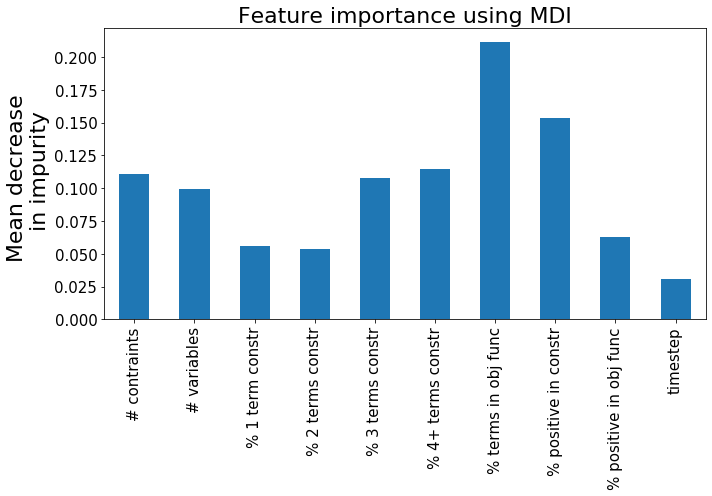

In [13]:
#Grafico feature importances
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

forest_importances = pd.Series(importances, index=feats)

fsize = 22

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, figsize = (10,7), fontsize=fsize-7)
plt.xticks(rotation=90, fontsize=fsize-7)
ax.set_title("Feature importance using MDI", fontsize=fsize)
ax.set_ylabel("Mean decrease \n in impurity", fontsize=fsize)
fig.tight_layout()

#print(importances)

# Prediction Time

In [9]:
#Calcular tiempos de predicción por cada par instancia-tiempo de test
#(Correr esto se demora)

l=int(len(y_pred)/500)
t_preds=np.empty(l*500)
i=0

#prediccion
for idx in test_indx:
    #crear dataframe de solo esa instancia-timestep
    x_i = x.iloc[[idx]]
    
    #hacer predicción y medir tiempo
    start=time.time()
    y_i = gbc_model.predict(np.nan_to_num(x_i.astype(np.float32)))
    tiempo=time.time()-start
    t_preds[i]=tiempo
    
    i=i+1

In [10]:
#Guardar tiempos de prediccion

print(t_preds)
f = open(main_path+"models/results-v4/pred_times/t_pred_gradientBoost_linear-v4.txt", "w")
np.savetxt(f, t_preds, delimiter=" ", fmt="%s")
f.close()

[0.00171399 0.00120234 0.00119996 ... 0.00082946 0.00083494 0.00083351]


https://www.tutorialspoint.com/scikit_learn/scikit_learn_boosting_methods.htm#

https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/

https://towardsdatascience.com/gradient-boosting-classification-explained-through-python-60cc980eeb3d